In [1]:
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import usphere_utils as uu
from datetime import date

In [34]:
## make some job files
num_per_chunk = 1e7
nmc_zero_mass = 1e10
nmc_nonzero_mass = 1e8
num_reps_per_file = 100

iso_list = ["p_32", "y_90", "s_35"] #, "ar_37", "be_7", "v_49", "cr_51", "fe_55", "ge_68", "se_72"]

params_list = [[50, 1e5], 
               [100, 1e5]]

dsq_file = "/Users/dcmoore/grace/impulse/steriles/dsq_jobs.sh"
dsqf = open(dsq_file, 'wt')
dsqf.write("#!/bin/bash\n")

## now make the file to submit to SLURM
sub_file = "/Users/dcmoore/grace/impulse/steriles/sub_dsq_jobs.sh"
subf = open(sub_file, 'wt')
subf.write("#!/bin/bash\n")

datestr = date.today().strftime("%Y-%m-%d")

for iso in iso_list:

    for params in params_list:

        sphere_rad = params[0]
        f0 = params[1]

        mnu = 0
        job_file = "/Users/dcmoore/grace/impulse/steriles/job_files/%s_jobs_%.1f_%.1e.txt"%(iso,sphere_rad,f0)
        jf = open(job_file, 'wt')
        nchunks = int(nmc_zero_mass/(num_reps_per_file*num_per_chunk))
        print(nchunks)
        for i in range(nchunks):
            jf.write("module load miniconda; source activate; conda activate py37_dev; python calculate_pdfs.py %s %.1f %.1f %.1e %d %d\n"%(iso, mnu, sphere_rad, f0, num_reps_per_file, i))
        jf.close()

        # 100 reps and 1e7 per chunk is 1.5 gb and 15 minutes
        dsqf.write("dsq --job-file job_files/%s_jobs_%.1f_%.1e.txt --mem-per-cpu 4g -t 60:00 --mail-type NONE\n"%(iso,sphere_rad,f0))
        subf.write("sbatch dsq-%s_jobs_%.1f_%.1e-%s.sh\n"%(iso,sphere_rad,f0,datestr))

        ## now for non zero masses
        job_file = "/Users/dcmoore/grace/impulse/steriles/job_files/%s_nonzero_jobs_%.1f_%.1e.txt"%(iso,sphere_rad,f0)
        jf = open(job_file, 'wt')
        num_reps_per_file = int(nmc_nonzero_mass/num_per_chunk)
        iso_dat = np.loadtxt("/Users/dcmoore/grace/impulse/steriles/data_files/%s.txt"%iso, delimiter=',', skiprows=3)
        Q, t12, A, Z = iso_dat[0, :]
        ## now as a function of sterile mass
        mass_list = np.linspace(1, Q, 100)
        nmasses_per_file = 5
        nchunks = int(len(mass_list)/nmasses_per_file)
        for i in range(nchunks):
            curr_masses = mass_list[(i*nmasses_per_file):((i+1)*nmasses_per_file)]
            curr_str = ["%.1f"%j for j in curr_masses]
            mnu = ','.join(curr_str)
            jf.write("module load miniconda; source activate; conda activate py37_dev; python calculate_pdfs.py %s %s %.1f %.1e %d %d\n"%(iso, mnu, sphere_rad, f0, num_reps_per_file, 0))
        jf.close()

        # 10 reps x 5 masses and 1e7 per chunk is 1.5 gb and 7.5 minutes
        dsqf.write("dsq --job-file job_files/%s_nonzero_jobs_%.1f_%.1e.txt --mem-per-cpu 4g -t 60:00 --mail-type NONE\n"%(iso,sphere_rad,f0))
        subf.write("sbatch dsq-%s_nonzero_jobs_%.1f_%.1e-%s.sh\n"%(iso,sphere_rad,f0,datestr))
dsqf.close()
subf.close()



10
100
100
100
100
100


(249, 2) (249, 249)
[242.8, 501.8, 743.6, 1002.6, 1244.4, 1503.4]
working on mass:  242.8
working on mass:  501.8
working on mass:  743.6
working on mass:  1002.6
working on mass:  1244.4
working on mass:  1503.4


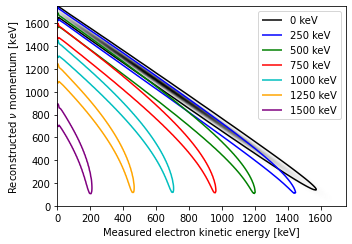

In [2]:
iso = 'p_32'

params = [50, 1e5]

save_dir = '/Users/dcmoore/grace/impulse/steriles/pdfs/'
of = open(save_dir + '%s_%.1f_%.1e_pdfs.pkl'%(iso,params[0],params[1]), 'rb')
pdfs = pickle.load(of)
of.close()


mass_list_str = pdfs.keys()
mass_list = []
for m in mass_list_str:
  cmass = float(m)
  if(cmass > 0):
    mass_list.append(cmass)

mass_list = sorted(mass_list)

ulim = np.ones_like(mass_list)*1e6

fig=plt.figure()

bkg_pdf = pdfs['0.0']
levs = [0.05,]

if( not iso in uu.beta_list):
  plt.semilogy(bkg_pdf[:,0], bkg_pdf[:,1], 'k')
else:
  x = bkg_pdf[:,:2]
  p = bkg_pdf[:,2:]
  print(np.shape(x), np.shape(p))
  p = p/np.max(p)
  #p[p==0] = np.nan
  p_orig = 1.0*p
  cs=plt.contour(x[:,0], x[:,1], p.T, levels=levs, colors='k')
  cs.collections[0].set_label("0 keV")
  plt.pcolormesh(x[:,0], x[:,1], p.T, cmap="Greys", rasterized=True, shading='gouraud')

  #plt.colorbar()
  #plt.title("$m_4 = 0$ keV")
  plt.xlabel("Measured electron kinetic energy [keV]")
  plt.ylabel(r"Reconstructed $\nu$ momentum [keV]")

ml = [250, 500, 750, 1000, 1250, 1500]
ml_idx = []
for mm in ml:
  ml_idx.append( mass_list[np.argmin(np.abs(np.array(mass_list)-mm))] )

print(ml_idx)

#plt.figure()

colors=['Greys', 'Blues', 'Greens', 'Reds', 'Oranges', 'Purples']
lcs = ['b', 'g', 'r', 'c', 'orange', 'purple']

cidx = 0
for i,m in enumerate(mass_list):

  if not m in ml_idx:
    continue

  print("working on mass: ", m)


  sig_pdf = pdfs['%.1f'%m]

  if( not iso in uu.beta_list):
    plt.semilogy(sig_pdf[:,0], sig_pdf[:,1])
  else:
    x = sig_pdf[:,:2]
    p = sig_pdf[:,2:]
    p = p/np.max(p)
    x = x[()] ## get the dict back from the 0d ndarray
    #plt.contour([x['bcx'], x['bcy']], p.T) #, levels=levs)
    #p[p<1e-4] = np.nan
    
    #plt.pcolormesh(x[:,0], x[:,1], p.T, cmap=colors[cidx])

    #plt.colorbar()
    cs=plt.contour(x[:,0], x[:,1], p.T, levels=levs, colors=lcs[cidx])
    cs.collections[0].set_label("%d keV"%(np.round(m/50)*50))
    cidx += 1
    #plt.title("$m_4 = %.1f$ keV"%m)
    plt.xlabel("Measured electron kinetic energy [keV]")
    plt.ylabel(r"Reconstructed $\nu$ momentum [keV]")

plt.xlim([0,1750])
plt.ylim([0,1750])
plt.legend()

fig.set_size_inches(5,3.5)
plt.tight_layout()
plt.savefig('p_32_2dplot.pdf')

plt.show()

In [5]:
def plot_limits(iso_list, isEC, fig, params_to_use, clist, fill=True, ls='-'):

    plt.figure(fig.number)
  
    for j,iso in enumerate(iso_list):

        flist = glob.glob("/Users/dcmoore/grace/impulse/steriles/limits/%s*%.1e_%d_%.1f_%.1f_%.1e.npz"%(iso,*params_to_use))
        iso_dat = np.loadtxt("/Users/dcmoore/grace/impulse/steriles/data_files/%s.txt"%iso, delimiter=',', skiprows=3)
        Q, t12, A, Z = iso_dat[0, :]

        for i,f in enumerate(flist):

            cdat = np.load(f)
            x = cdat['m']
            lim_vals = cdat['lim']
            
            good_vals = np.where(~(np.isnan(lim_vals)))[0] ## put to flat value at high mass (prior to phase space below)
            lim_vals[good_vals[-1]:] = lim_vals[good_vals[-1]]
            lim_vals[0] = np.nan
            
            if(iso == "be_7"):
                Q = 384.22 ## hard code the gamma that gets subtracted
                        ## should fix this for general case (maybe do this in the limit step or pdf?)
            xfine = np.linspace(x[0], Q, 100000)
            limfine = np.interp(xfine, x, lim_vals, left=np.nan, right=np.nan)

            if(isEC):
                massfac = np.sqrt(1 - xfine**2/Q**2)
            else:
                massfac = np.zeros_like(xfine)
                ee = np.linspace(0,Q,1000)
                massless_beta_norm = np.sum(uu.simple_beta(ee, Q, 0, A, Z))
                for mi, ms in enumerate(xfine):
                    massfac[mi] = np.sum(uu.simple_beta(ee, Q, ms, A, Z))/massless_beta_norm

            Q_idx = np.argmin(np.abs(xfine - Q))
            massfac[Q_idx] = 1e-10
            limfine /= massfac

            ## trim any nans and maker sure plot reaches top
            g = ~np.isnan(limfine)
            xfine, limfine = xfine[g], limfine[g]
            xfine = np.append(xfine, xfine[-1]+1e-15)
            limfine = np.append(limfine, 1)

            if(not i==0):
                p=plt.semilogy( xfine, limfine, ":", color=clist[i] )
                c=p[0].get_color()
                plt.fill_between(xfine, limfine, np.ones_like(limfine), edgecolor='none', facecolor=c, alpha=0.05)
            else:
                Z,A = iso.split('_')
                lab = "$^{%s}$%s"%( A, Z.capitalize() )
                if(fill):
                    p=plt.semilogy( xfine, limfine, ls, label=lab, color=clist[j])
                else:
                    p=plt.semilogy( xfine, limfine, ls, color=clist[j])
                c=p[0].get_color()
                if(fill):
                    plt.fill_between(xfine, limfine, np.ones_like(limfine), edgecolor='none', facecolor=c, alpha=0.2)

    plt.ylim([1e-6,1])
    #plt.gca().set_xscale('log')
    if(isEC):
        plt.xlim([0,1100])
    else:
        plt.xlim([0,2500])
    plt.xlabel(r"Sterile $\nu$ mass, $m_4$ [keV]")
    plt.ylabel("$|U_{e4}|^2$")
    plt.legend()

ValueError: too many values to unpack (expected 3)

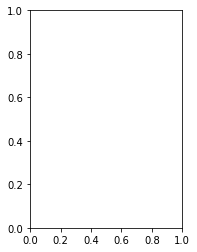

In [39]:
## plot for the paper (EC)

clist = plt.rcParams['axes.prop_cycle'].by_key()['color']

params = [1e-2, 1, 100, 50, 1e5] ## 1% loading, 100 sphere days

iso_list = ["ar_37", "v_49", "cr_51", "ge_68", "se_72"]
isEC = True

fig=plt.figure()
plt.subplot(1,2,1)
plot_limits(iso_list, isEC, fig, params, clist)

## all done with 100 nm sphere except s_35 with 50 nm
nprev = len(iso_list)
iso_list = ["p_32","s_35","y_90"]
isEC = False

clist = clist[nprev:]
plt.subplot(1,2,2)
plot_limits(iso_list, isEC, fig, params, clist)
fig.set_size_inches(11,3.5)
plt.tight_layout()

plt.savefig("ue4_sensitivity.pdf")
plt.show()

curr dir:  /Volumes/GoogleDrive-108630187434314716047/My Drive/yale/uspheres/impulse/impulse/steriles


/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_12271/3812837355.py:39: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
No handles with labels found to put in legend.
/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_12271/3812837355.py:39: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
No handles with labels found to put in legend.
/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_12271/3812837355.py:39: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
No handles with labels found to put in legend.


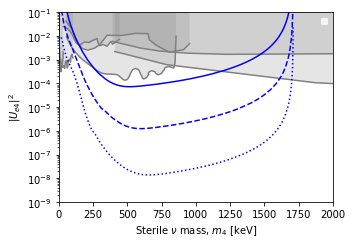

In [52]:
## plot the previous limits with the projections overlaid

prev_iso = ['be_7', 's_35', 're_187', 'ni_63', 'h_3', 'f_20', 'cu_64', 'ce_144', 'pienu']

fig=plt.figure()

print("curr dir: ", os.getcwd())

for piso in prev_iso:

    f = "/Users/dcmoore/grace/impulse/steriles/prev_lim/prev_lim_%s.txt"%piso
    curr_dat = np.loadtxt(f, delimiter=',', skiprows=1)

    p=plt.semilogy(curr_dat[:,0]*1e6, curr_dat[:,1], color='grey')
    c=p[0].get_color()
    plt.fill_between(curr_dat[:,0]*1e6, curr_dat[:,1], np.ones_like(curr_dat[:,1]), edgecolor='none', facecolor='grey', alpha=0.2)

nprev = len(iso_list)
iso_list = ["p_32",]
isEC = False

params_list = [[1e-2, 1, 10],
               [1e-2, 1, 365],
               [1e-2, 100, 365]] 

clist = ['b',]
lslist = ['-', '--', ':']
for ls,params in zip(lslist,params_list):
    plot_limits(iso_list, isEC, fig, params, clist, fill=False, ls=ls)
plt.tight_layout()

plt.xlim([0,2000])
plt.ylim([1e-9, 0.1])

fig.set_size_inches(5,3.5)
plt.tight_layout()

plt.savefig("ue4_sens_vs_livetime.pdf")
plt.show()
    

/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_2763/4008851229.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
No handles with labels found to put in legend.


(1e-09, 0.1)

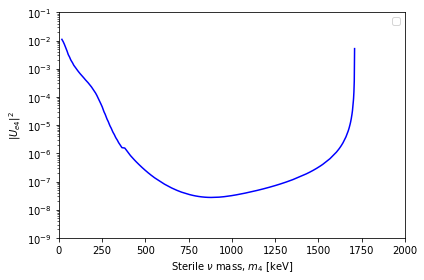

In [6]:
##plot vs sphere size

iso_list = ["p_32",]
isEC = False

params_list = [[1e-2, 10, 365, 50, 1e5],
               [1e-2, 10, 365, 100, 1e5],] 

clist = ['b',]
lslist = ['-', '--']
for ls,params in zip(lslist,params_list):
    plot_limits(iso_list, isEC, fig, params, clist, fill=False, ls=ls)
plt.tight_layout()

plt.xlim([0,2000])
plt.ylim([1e-9, 0.1])